C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/100
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0128 - val_loss: 0.0028

Epoch 00001: val_loss improved from inf to 0.00276, saving model to DNNLSTMWmodel.h5
Epoch 2/100
3847/3847 [==============================] - 2s 392us/step - loss: 0.0040 - val_loss: 0.0044

Epoch 00002: val_loss did not improve from 0.00276
Epoch 3/100
3847/3847 [==============================] - 1s 380us/step - loss: 0.0037 - val_loss: 0.0045

Epoch 00003: val_loss did not improve from 0.00276
Epoch 4/100
3847/3847 [==============================] - 2s 430us/step - loss: 0.0039 - val_loss: 0.0085

Epoch 00004: val_loss did not improve from 0.00276
Epoch 5/100
3847/3847 [==============================] - 2s 466us/step - loss: 0.0039 - val_loss: 0.0031

Epoch 00005: val_loss did not improve from 0.00276
Epoch 6/100
3847/3847 [==============================] - 2s 471us/step - loss: 0.0034 - val_loss: 0.0043



3847/3847 [==============================] - 2s 459us/step - loss: 0.0024 - val_loss: 0.0042

Epoch 00052: val_loss did not improve from 0.00227
Epoch 53/100
3847/3847 [==============================] - 2s 459us/step - loss: 0.0025 - val_loss: 0.0039

Epoch 00053: val_loss did not improve from 0.00227
Epoch 54/100
3847/3847 [==============================] - 2s 438us/step - loss: 0.0025 - val_loss: 0.0028

Epoch 00054: val_loss did not improve from 0.00227
Epoch 55/100
3847/3847 [==============================] - 2s 474us/step - loss: 0.0025 - val_loss: 0.0040

Epoch 00055: val_loss did not improve from 0.00227
Epoch 56/100
3847/3847 [==============================] - 2s 487us/step - loss: 0.0024 - val_loss: 0.0038

Epoch 00056: val_loss did not improve from 0.00227
Epoch 57/100
3847/3847 [==============================] - 2s 475us/step - loss: 0.0024 - val_loss: 0.0039

Epoch 00057: val_loss did not improve from 0.00227
Epoch 58/100
3847/3847 [==============================] - 2s 463u

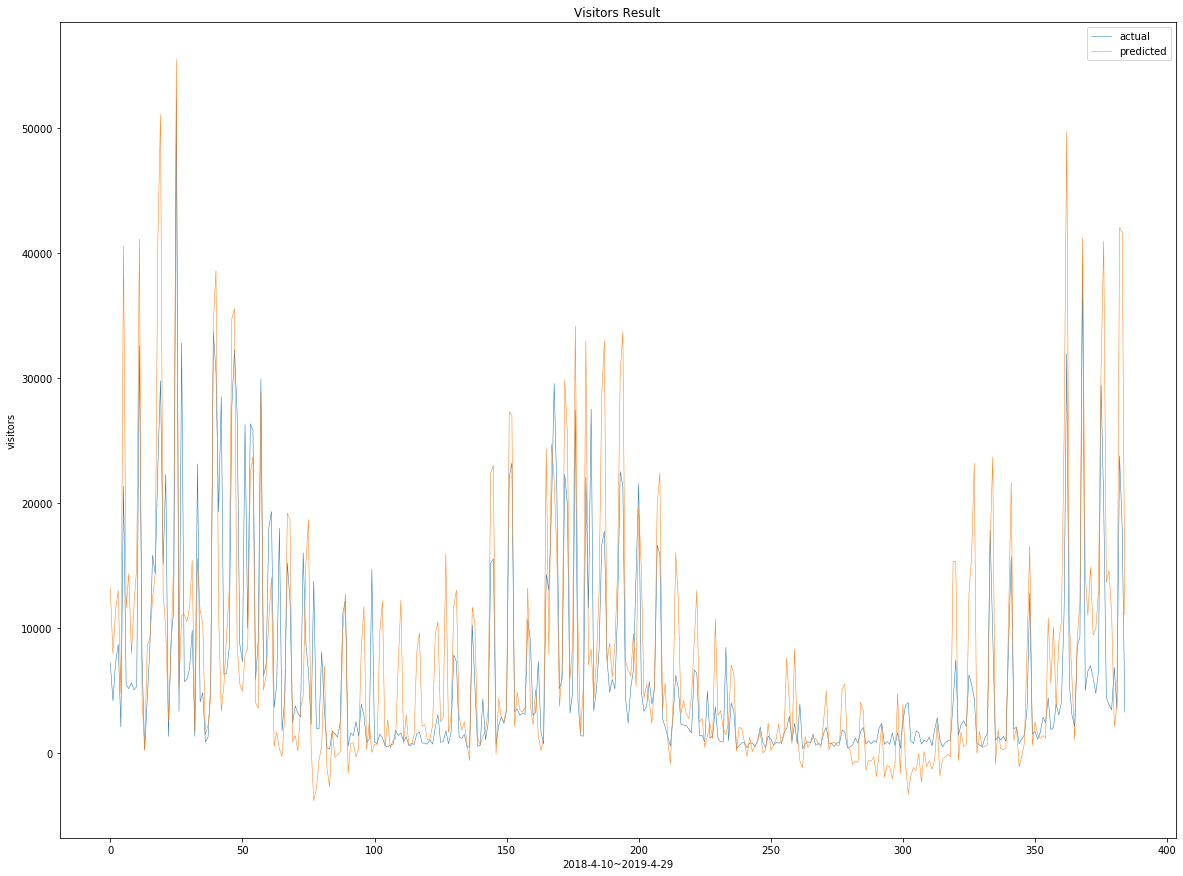

mae :  3745.7815799583086
mse :  34117783.03001172
rmse :  5841.042974504786
std : 5703.766348462501


In [2]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='val_loss', patience=80, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=100, batch_size=100, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/100
3847/3847 [==============================] - 10s 2ms/step - loss: 0.0123 - val_loss: 0.0037

Epoch 00001: val_loss improved from inf to 0.00370, saving model to DNNLSTMWmodel.h5
Epoch 2/100
3847/3847 [==============================] - 3s 684us/step - loss: 0.0043 - val_loss: 0.0037

Epoch 00002: val_loss did not improve from 0.00370
Epoch 3/100
3847/3847 [==============================] - 3s 686us/step - loss: 0.0036 - val_loss: 0.0027

Epoch 00003: val_loss improved from 0.00370 to 0.00266, saving model to DNNLSTMWmodel.h5
Epoch 4/100
3847/3847 [==============================] - 3s 701us/step - loss: 0.0035 - val_loss: 0.0039

Epoch 00004: val_loss did not improve from 0.00266
Epoch 5/100
3847/3847 [==============================] - 3s 697us/step - loss: 0.0037 - val_loss: 0.0036

Epoch 00005: val_loss did not improve from 0.00266
Epoch 6/100
3847/3847 [==============================] - 3s 708us/s

3847/3847 [==============================] - 2s 638us/step - loss: 0.0024 - val_loss: 0.0029

Epoch 00051: val_loss did not improve from 0.00239
Epoch 52/100
3847/3847 [==============================] - 3s 673us/step - loss: 0.0024 - val_loss: 0.0031

Epoch 00052: val_loss did not improve from 0.00239
Epoch 53/100
3847/3847 [==============================] - 3s 688us/step - loss: 0.0025 - val_loss: 0.0036

Epoch 00053: val_loss did not improve from 0.00239
Epoch 54/100
3847/3847 [==============================] - 2s 600us/step - loss: 0.0024 - val_loss: 0.0030

Epoch 00054: val_loss did not improve from 0.00239
Epoch 55/100
3847/3847 [==============================] - 2s 645us/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00055: val_loss did not improve from 0.00239
Epoch 56/100
3847/3847 [==============================] - 2s 597us/step - loss: 0.0025 - val_loss: 0.0029

Epoch 00056: val_loss did not improve from 0.00239
Epoch 57/100
3847/3847 [==============================] - 2s 605u

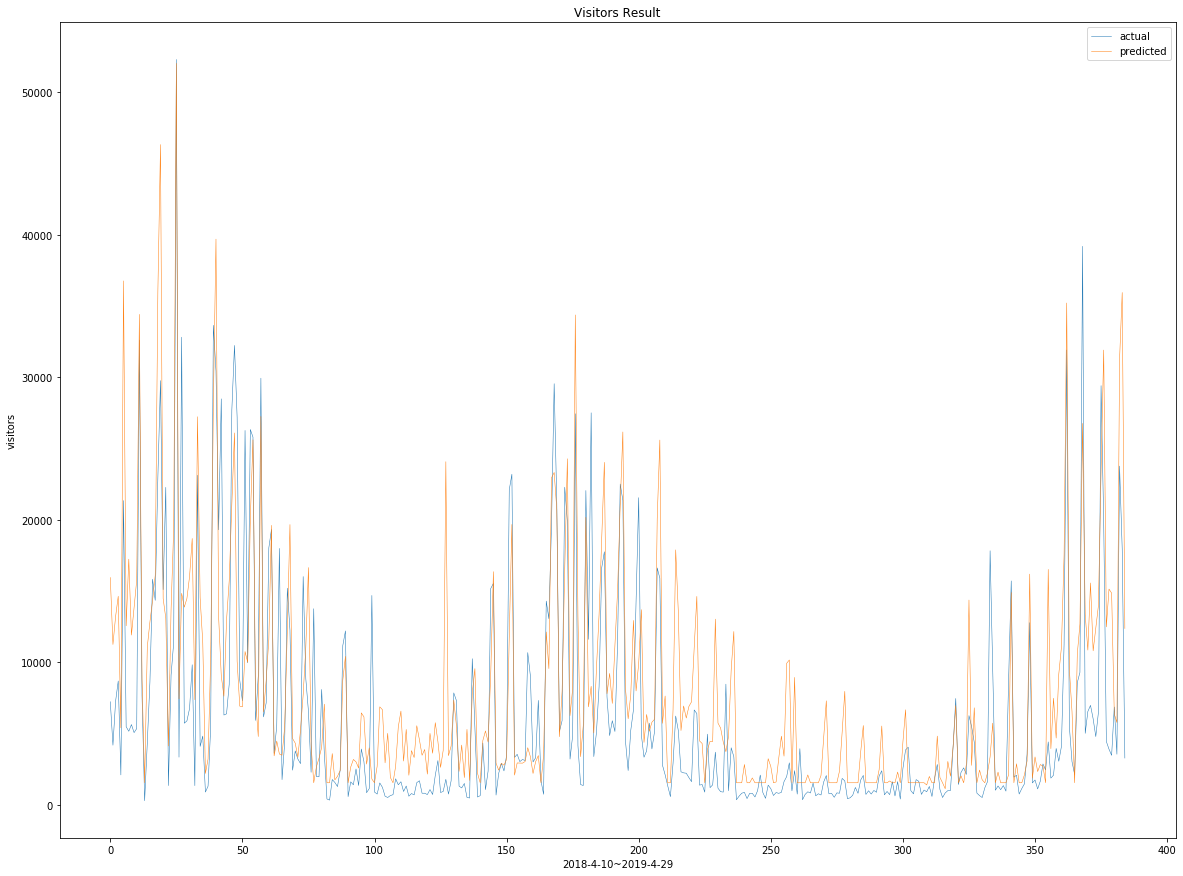

mae :  3558.0587982574066
mse :  27053782.001989894
rmse :  5201.325023682897
std : 4920.450537785596


In [3]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=100, batch_size=100, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/70
3847/3847 [==============================] - 8s 2ms/step - loss: 0.0071 - val_loss: 0.0041

Epoch 00001: val_loss improved from inf to 0.00411, saving model to DNNLSTMWmodel.h5
Epoch 2/70
3847/3847 [==============================] - 3s 771us/step - loss: 0.0042 - val_loss: 0.0039

Epoch 00002: val_loss improved from 0.00411 to 0.00390, saving model to DNNLSTMWmodel.h5
Epoch 3/70
3847/3847 [==============================] - 3s 749us/step - loss: 0.0037 - val_loss: 0.0069

Epoch 00003: val_loss did not improve from 0.00390
Epoch 4/70
3847/3847 [==============================] - 3s 779us/step - loss: 0.0037 - val_loss: 0.0040

Epoch 00004: val_loss did not improve from 0.00390
Epoch 5/70
3847/3847 [==============================] - 3s 805us/step - loss: 0.0033 - val_loss: 0.0039

Epoch 00005: val_loss improved from 0.00390 to 0.00385, saving model to DNNLSTMWmodel.h5
Epoch 6/70
3847/3847 [=============

3847/3847 [==============================] - 3s 878us/step - loss: 0.0023 - val_loss: 0.0027

Epoch 00051: val_loss did not improve from 0.00193
Epoch 52/70
3847/3847 [==============================] - 3s 872us/step - loss: 0.0023 - val_loss: 0.0027

Epoch 00052: val_loss did not improve from 0.00193
Epoch 53/70
3847/3847 [==============================] - 3s 826us/step - loss: 0.0023 - val_loss: 0.0033

Epoch 00053: val_loss did not improve from 0.00193
Epoch 54/70
3847/3847 [==============================] - 3s 836us/step - loss: 0.0022 - val_loss: 0.0030

Epoch 00054: val_loss did not improve from 0.00193
Epoch 55/70
3847/3847 [==============================] - 3s 840us/step - loss: 0.0023 - val_loss: 0.0030

Epoch 00055: val_loss did not improve from 0.00193
Epoch 56/70
3847/3847 [==============================] - 4s 910us/step - loss: 0.0023 - val_loss: 0.0031

Epoch 00056: val_loss did not improve from 0.00193
Epoch 57/70
3847/3847 [==============================] - 3s 838us/step

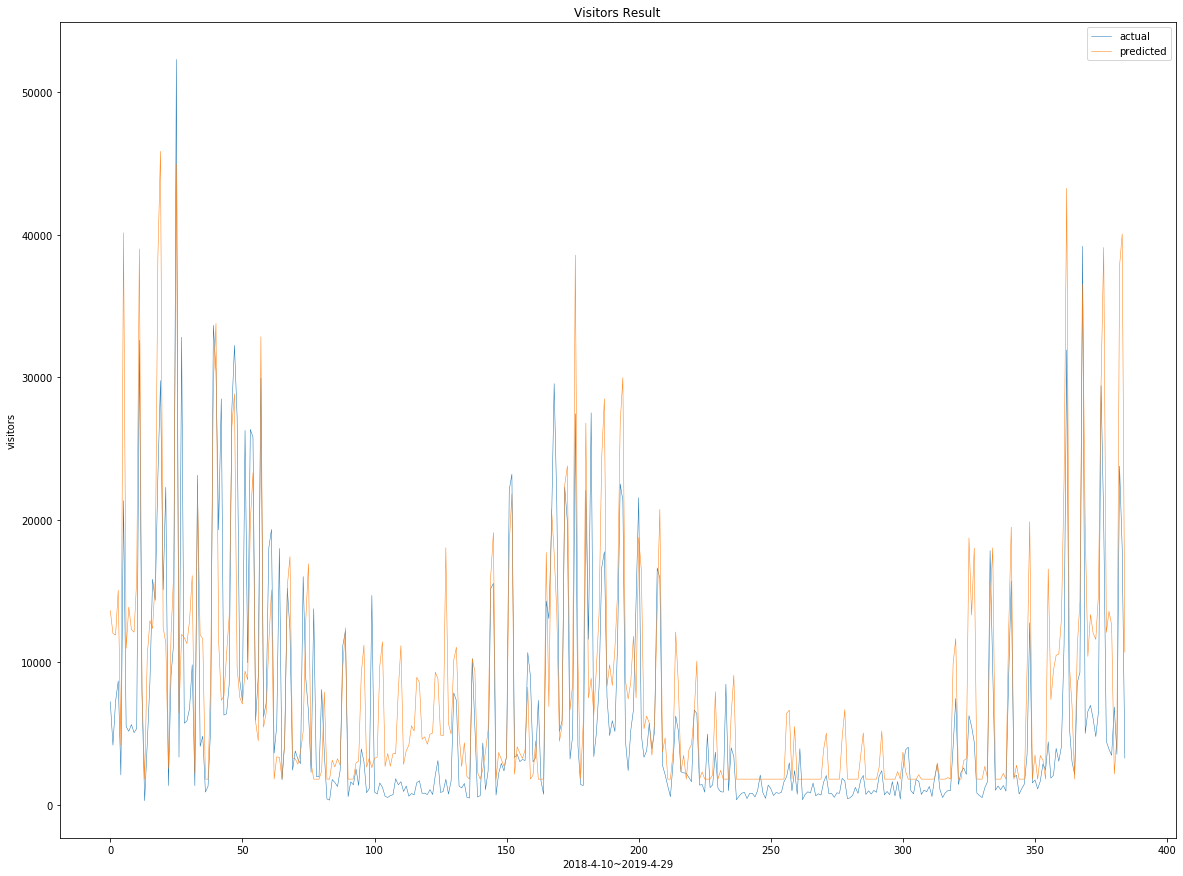

mae :  3572.919455154221
mse :  28676698.424582157
rmse :  5355.062877743095
std : 5012.932464250002


In [4]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=70, batch_size=50, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/70
3847/3847 [==============================] - 8s 2ms/step - loss: 0.0080 - val_loss: 0.0037

Epoch 00001: val_loss improved from inf to 0.00372, saving model to DNNLSTMWmodel.h5
Epoch 2/70
3847/3847 [==============================] - 3s 798us/step - loss: 0.0042 - val_loss: 0.0034

Epoch 00002: val_loss improved from 0.00372 to 0.00342, saving model to DNNLSTMWmodel.h5
Epoch 3/70
3847/3847 [==============================] - 3s 785us/step - loss: 0.0041 - val_loss: 0.0040

Epoch 00003: val_loss did not improve from 0.00342
Epoch 4/70
3847/3847 [==============================] - 3s 765us/step - loss: 0.0036 - val_loss: 0.0039

Epoch 00004: val_loss did not improve from 0.00342
Epoch 5/70
3847/3847 [==============================] - 3s 766us/step - loss: 0.0035 - val_loss: 0.0042

Epoch 00005: val_loss did not improve from 0.00342
Epoch 6/70
3847/3847 [==============================] - 3s 776us/step - l

3847/3847 [==============================] - 3s 853us/step - loss: 0.0025 - val_loss: 0.0028

Epoch 00051: val_loss did not improve from 0.00248
Epoch 52/70
3847/3847 [==============================] - 3s 848us/step - loss: 0.0026 - val_loss: 0.0023

Epoch 00052: val_loss improved from 0.00248 to 0.00232, saving model to DNNLSTMWmodel.h5
Epoch 53/70
3847/3847 [==============================] - 3s 856us/step - loss: 0.0024 - val_loss: 0.0031

Epoch 00053: val_loss did not improve from 0.00232
Epoch 54/70
3847/3847 [==============================] - 3s 849us/step - loss: 0.0024 - val_loss: 0.0026

Epoch 00054: val_loss did not improve from 0.00232
Epoch 55/70
3847/3847 [==============================] - 3s 854us/step - loss: 0.0024 - val_loss: 0.0033

Epoch 00055: val_loss did not improve from 0.00232
Epoch 56/70
3847/3847 [==============================] - 3s 854us/step - loss: 0.0024 - val_loss: 0.0036

Epoch 00056: val_loss did not improve from 0.00232
Epoch 57/70
3847/3847 [=========

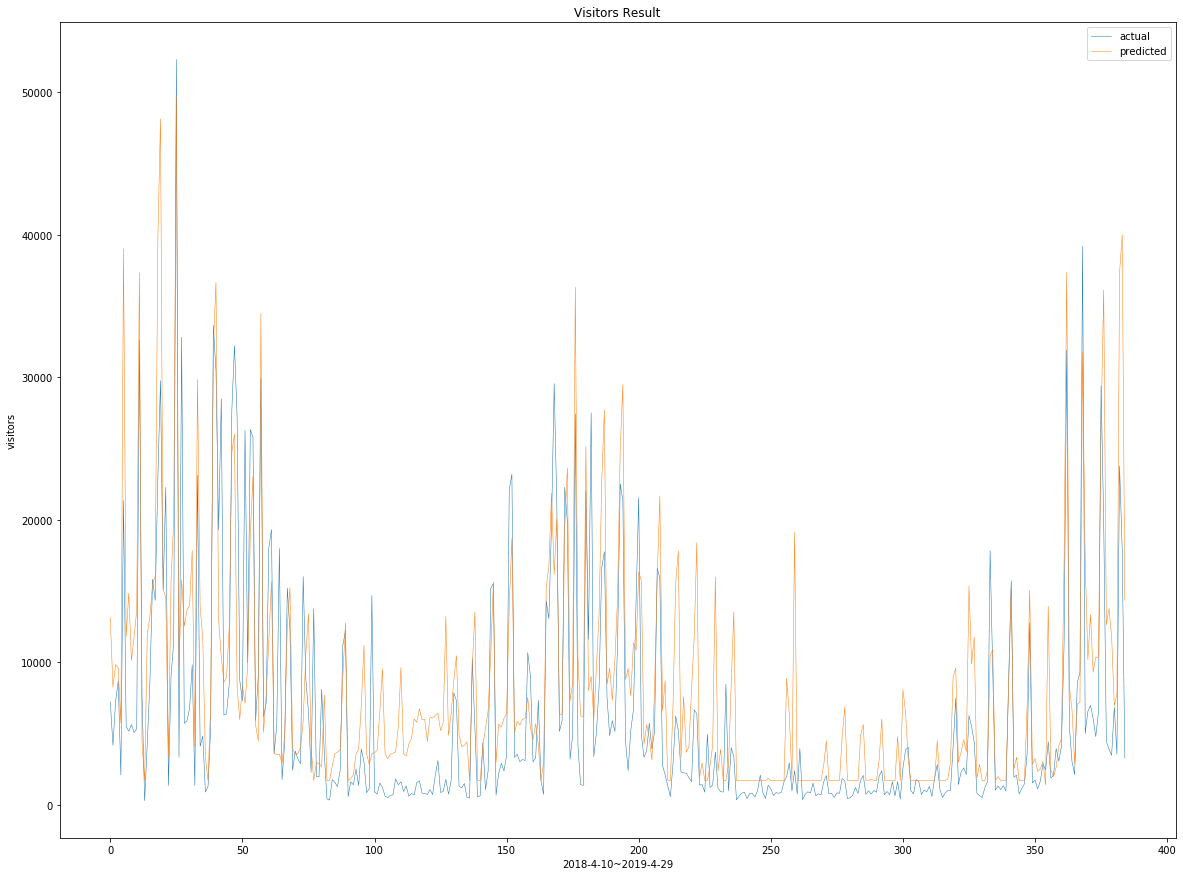

mae :  3614.778244216721
mse :  27547634.657500565
rmse :  5248.584062154341
std : 4851.519920508922


In [5]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=70, batch_size=50, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/70
3847/3847 [==============================] - 11s 3ms/step - loss: 0.0078 - val_loss: 0.0061

Epoch 00001: val_loss improved from inf to 0.00605, saving model to DNNLSTMWmodel.h5
Epoch 2/70
3847/3847 [==============================] - 4s 958us/step - loss: 0.0042 - val_loss: 0.0021

Epoch 00002: val_loss improved from 0.00605 to 0.00211, saving model to DNNLSTMWmodel.h5
Epoch 3/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0037 - val_loss: 0.0025

Epoch 00003: val_loss did not improve from 0.00211
Epoch 4/70
3847/3847 [==============================] - 4s 936us/step - loss: 0.0035 - val_loss: 0.0040

Epoch 00004: val_loss did not improve from 0.00211
Epoch 5/70
3847/3847 [==============================] - 3s 906us/step - loss: 0.0034 - val_loss: 0.0028

Epoch 00005: val_loss did not improve from 0.00211
Epoch 6/70
3847/3847 [==============================] - 4s 914us/step - lo

3847/3847 [==============================] - 3s 883us/step - loss: 0.0024 - val_loss: 0.0029

Epoch 00052: val_loss did not improve from 0.00211
Epoch 53/70
3847/3847 [==============================] - 3s 888us/step - loss: 0.0023 - val_loss: 0.0028

Epoch 00053: val_loss did not improve from 0.00211
Epoch 54/70
3847/3847 [==============================] - 3s 887us/step - loss: 0.0023 - val_loss: 0.0033

Epoch 00054: val_loss did not improve from 0.00211
Epoch 55/70
3847/3847 [==============================] - 3s 906us/step - loss: 0.0023 - val_loss: 0.0026

Epoch 00055: val_loss did not improve from 0.00211
Epoch 56/70
3847/3847 [==============================] - 3s 896us/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00056: val_loss did not improve from 0.00211
Epoch 57/70
3847/3847 [==============================] - 3s 893us/step - loss: 0.0023 - val_loss: 0.0033

Epoch 00057: val_loss did not improve from 0.00211
Epoch 58/70
3847/3847 [==============================] - 4s 945us/step

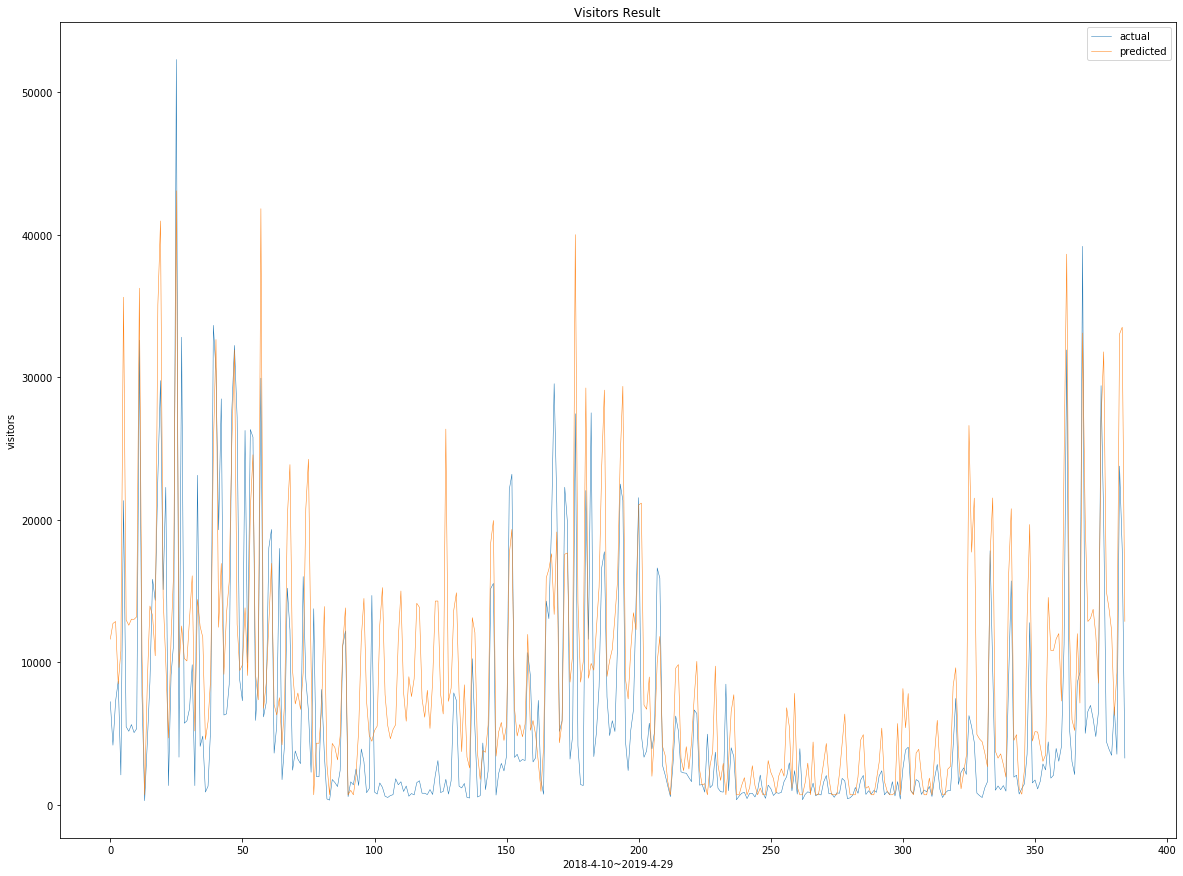

mae :  4377.515269727831
mse :  36087291.26317177
rmse :  6007.2698676829705
std : 5275.832131363653


In [6]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=70, batch_size=50, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/70
3847/3847 [==============================] - 11s 3ms/step - loss: 0.0096 - val_loss: 0.0050

Epoch 00001: val_loss improved from inf to 0.00505, saving model to DNNLSTMWmodel.h5
Epoch 2/70
3847/3847 [==============================] - 3s 867us/step - loss: 0.0040 - val_loss: 0.0030

Epoch 00002: val_loss improved from 0.00505 to 0.00299, saving model to DNNLSTMWmodel.h5
Epoch 3/70
3847/3847 [==============================] - 3s 852us/step - loss: 0.0036 - val_loss: 0.0038

Epoch 00003: val_loss did not improve from 0.00299
Epoch 4/70
3847/3847 [==============================] - 3s 854us/step - loss: 0.0035 - val_loss: 0.0033

Epoch 00004: val_loss did not improve from 0.00299
Epoch 5/70
3847/3847 [==============================] - 3s 867us/step - loss: 0.0035 - val_loss: 0.0053

Epoch 00005: val_loss did not improve from 0.00299
Epoch 6/70
3847/3847 [==============================] - 3s 852us/step - 

3847/3847 [==============================] - 4s 948us/step - loss: 0.0023 - val_loss: 0.0027

Epoch 00051: val_loss did not improve from 0.00214
Epoch 52/70
3847/3847 [==============================] - 4s 923us/step - loss: 0.0023 - val_loss: 0.0027

Epoch 00052: val_loss did not improve from 0.00214
Epoch 53/70
3847/3847 [==============================] - 4s 921us/step - loss: 0.0023 - val_loss: 0.0039

Epoch 00053: val_loss did not improve from 0.00214
Epoch 54/70
3847/3847 [==============================] - 4s 926us/step - loss: 0.0024 - val_loss: 0.0035

Epoch 00054: val_loss did not improve from 0.00214
Epoch 55/70
3847/3847 [==============================] - 4s 928us/step - loss: 0.0022 - val_loss: 0.0032

Epoch 00055: val_loss did not improve from 0.00214
Epoch 56/70
3847/3847 [==============================] - 4s 923us/step - loss: 0.0024 - val_loss: 0.0029 0s - loss: 0.002

Epoch 00056: val_loss did not improve from 0.00214
Epoch 57/70
3847/3847 [==============================

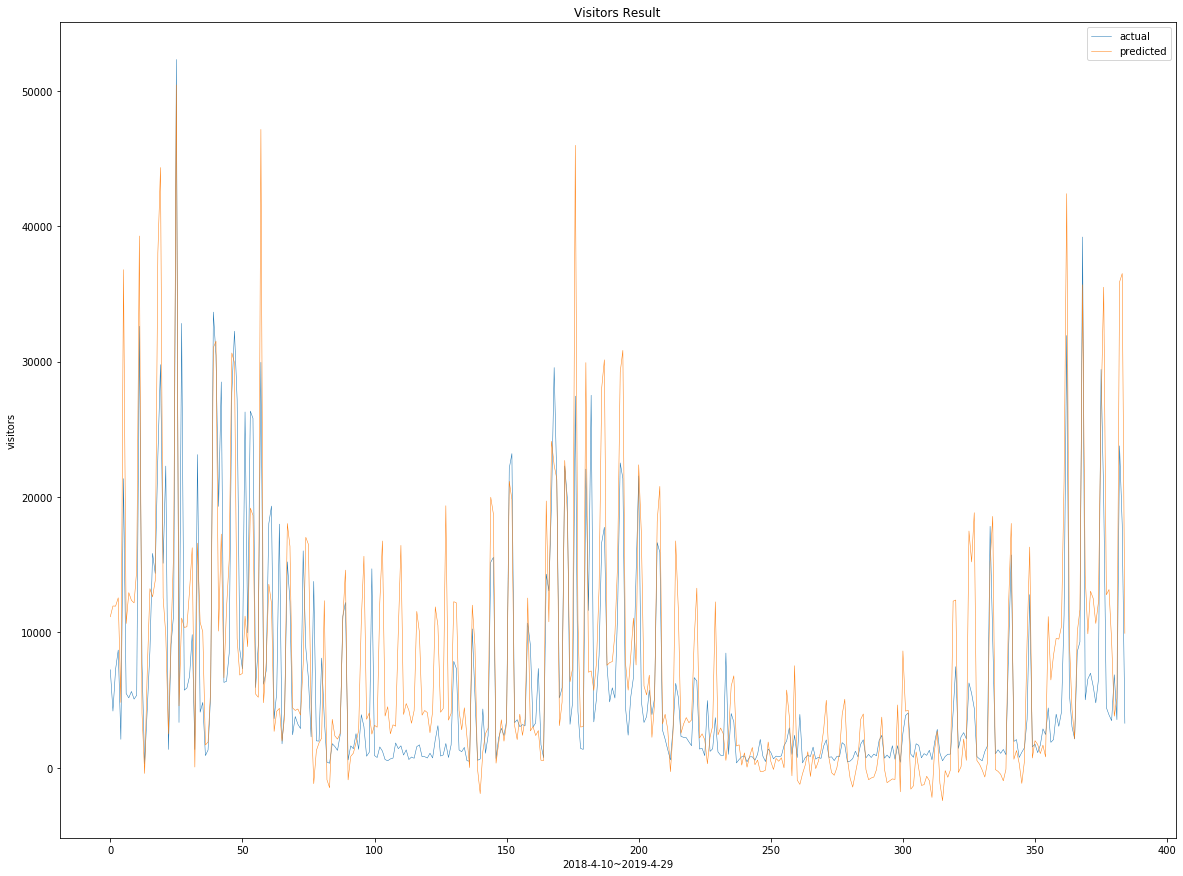

mae :  3634.419943288704
mse :  29064808.219168726
rmse :  5391.178741163079
std : 5191.36695207659


In [7]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=70, batch_size=50, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/70
3847/3847 [==============================] - 9s 2ms/step - loss: 0.0068 - val_loss: 0.0052

Epoch 00001: val_loss improved from inf to 0.00515, saving model to DNNLSTMWmodel.h5
Epoch 2/70
3847/3847 [==============================] - 4s 951us/step - loss: 0.0040 - val_loss: 0.0023

Epoch 00002: val_loss improved from 0.00515 to 0.00226, saving model to DNNLSTMWmodel.h5
Epoch 3/70
3847/3847 [==============================] - 3s 898us/step - loss: 0.0037 - val_loss: 0.0037

Epoch 00003: val_loss did not improve from 0.00226
Epoch 4/70
3847/3847 [==============================] - 3s 849us/step - loss: 0.0034 - val_loss: 0.0037

Epoch 00004: val_loss did not improve from 0.00226
Epoch 5/70
3847/3847 [==============================] - 3s 852us/step - loss: 0.0032 - val_loss: 0.0021

Epoch 00005: val_loss improved from 0.00226 to 0.00210, saving model to DNNLSTMWmodel.h5
Epoch 6/70
3847/3847 [=============


Epoch 00051: val_loss did not improve from 0.00198
Epoch 52/70
3847/3847 [==============================] - 3s 905us/step - loss: 0.0024 - val_loss: 0.0024

Epoch 00052: val_loss did not improve from 0.00198
Epoch 53/70
3847/3847 [==============================] - 3s 895us/step - loss: 0.0024 - val_loss: 0.0022

Epoch 00053: val_loss did not improve from 0.00198
Epoch 54/70
3847/3847 [==============================] - 3s 901us/step - loss: 0.0024 - val_loss: 0.0030

Epoch 00054: val_loss did not improve from 0.00198
Epoch 55/70
3847/3847 [==============================] - 4s 911us/step - loss: 0.0024 - val_loss: 0.0031

Epoch 00055: val_loss did not improve from 0.00198
Epoch 56/70
3847/3847 [==============================] - 3s 889us/step - loss: 0.0023 - val_loss: 0.0028

Epoch 00056: val_loss did not improve from 0.00198
Epoch 57/70
3847/3847 [==============================] - 3s 893us/step - loss: 0.0023 - val_loss: 0.0027

Epoch 00057: val_loss did not improve from 0.00198
Epoch 

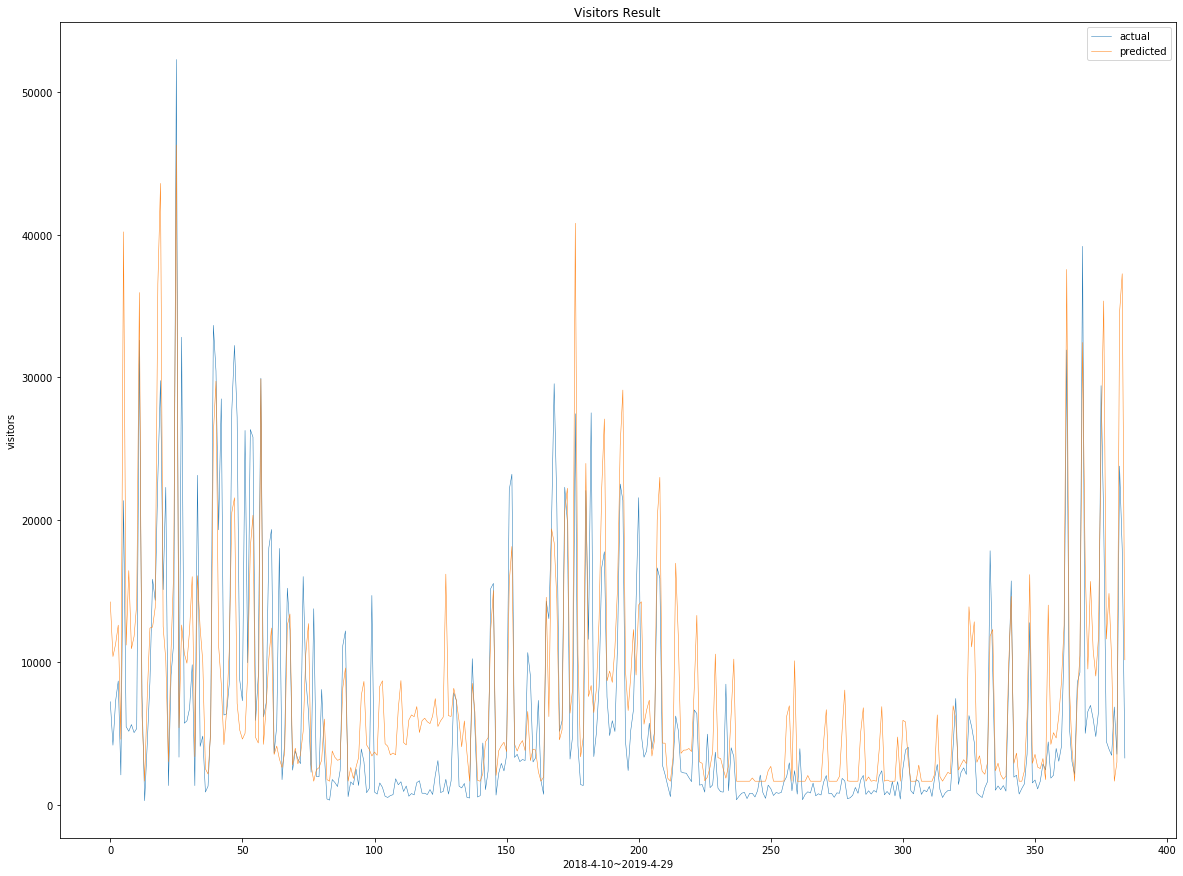

mae :  3473.805289290787
mse :  25827811.665978543
rmse :  5082.107010480844
std : 4885.040148175198


In [8]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=70, batch_size=50, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/70
3847/3847 [==============================] - 13s 3ms/step - loss: 0.0068 - val_loss: 0.0040

Epoch 00001: val_loss improved from inf to 0.00397, saving model to DNNLSTMWmodel.h5
Epoch 2/70
3847/3847 [==============================] - 3s 901us/step - loss: 0.0042 - val_loss: 0.0054

Epoch 00002: val_loss did not improve from 0.00397
Epoch 3/70
3847/3847 [==============================] - 3s 892us/step - loss: 0.0042 - val_loss: 0.0028

Epoch 00003: val_loss improved from 0.00397 to 0.00284, saving model to DNNLSTMWmodel.h5
Epoch 4/70
3847/3847 [==============================] - 3s 894us/step - loss: 0.0037 - val_loss: 0.0035

Epoch 00004: val_loss did not improve from 0.00284
Epoch 5/70
3847/3847 [==============================] - 3s 890us/step - loss: 0.0037 - val_loss: 0.0035

Epoch 00005: val_loss did not improve from 0.00284
Epoch 6/70
3847/3847 [==============================] - 3s 887us/step - 


Epoch 00051: val_loss did not improve from 0.00213
Epoch 52/70
3847/3847 [==============================] - 4s 971us/step - loss: 0.0023 - val_loss: 0.0030

Epoch 00052: val_loss did not improve from 0.00213
Epoch 53/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0022 - val_loss: 0.0026

Epoch 00053: val_loss did not improve from 0.00213
Epoch 54/70
3847/3847 [==============================] - 4s 993us/step - loss: 0.0022 - val_loss: 0.0029

Epoch 00054: val_loss did not improve from 0.00213
Epoch 55/70
3847/3847 [==============================] - 4s 984us/step - loss: 0.0022 - val_loss: 0.0030

Epoch 00055: val_loss did not improve from 0.00213
Epoch 56/70
3847/3847 [==============================] - 4s 979us/step - loss: 0.0022 - val_loss: 0.0036

Epoch 00056: val_loss did not improve from 0.00213
Epoch 57/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0022 - val_loss: 0.0032

Epoch 00057: val_loss did not improve from 0.00213
Epoch 58/7

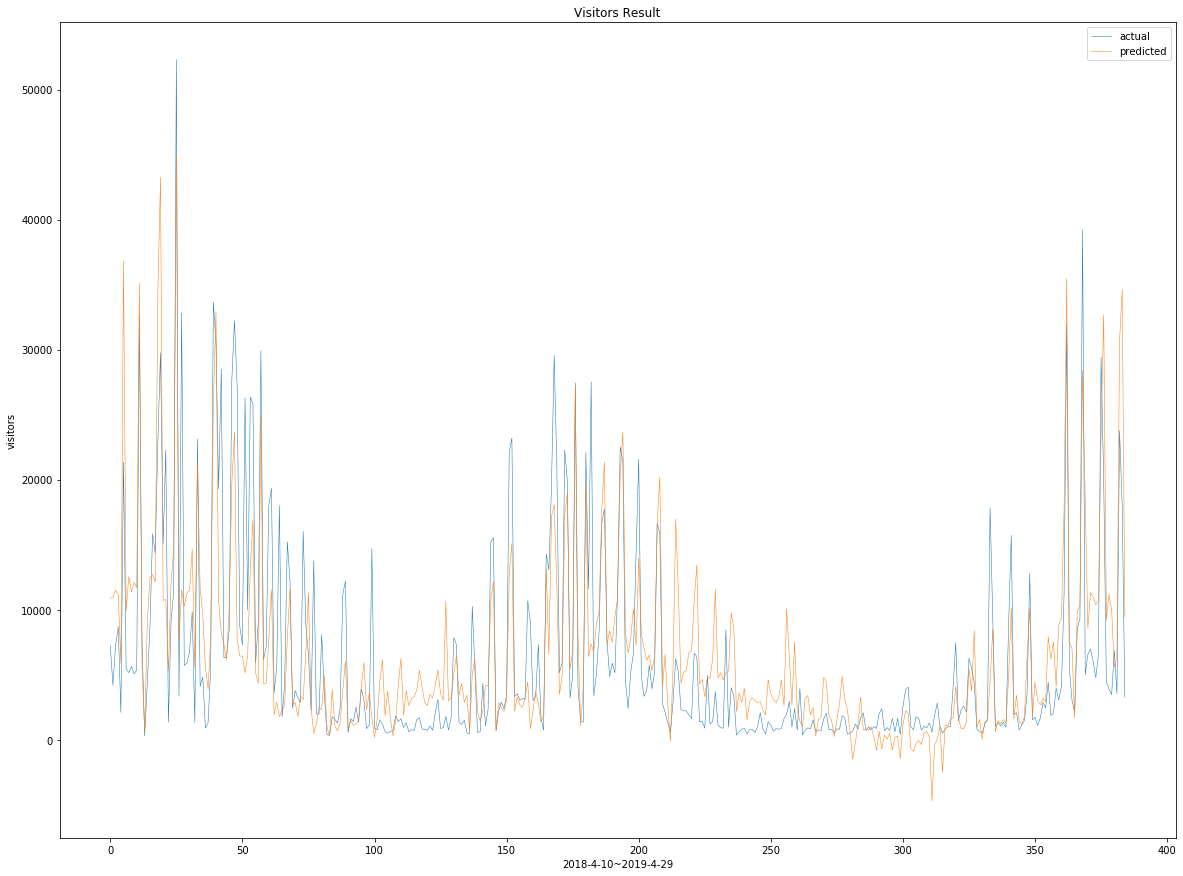

mae :  3298.656700872446
mse :  23734015.030123565
rmse :  4871.756873051401
std : 4858.97610563579


In [9]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=70, batch_size=50, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/70
3847/3847 [==============================] - 15s 4ms/step - loss: 0.0084 - val_loss: 0.0041

Epoch 00001: val_loss improved from inf to 0.00413, saving model to DNNLSTMWmodel.h5
Epoch 2/70
3847/3847 [==============================] - 4s 942us/step - loss: 0.0043 - val_loss: 0.0037

Epoch 00002: val_loss improved from 0.00413 to 0.00373, saving model to DNNLSTMWmodel.h5
Epoch 3/70
3847/3847 [==============================] - 4s 936us/step - loss: 0.0035 - val_loss: 0.0044

Epoch 00003: val_loss did not improve from 0.00373
Epoch 4/70
3847/3847 [==============================] - 4s 930us/step - loss: 0.0037 - val_loss: 0.0033

Epoch 00004: val_loss improved from 0.00373 to 0.00327, saving model to DNNLSTMWmodel.h5
Epoch 5/70
3847/3847 [==============================] - 4s 946us/step - loss: 0.0035 - val_loss: 0.0030

Epoch 00005: val_loss improved from 0.00327 to 0.00304, saving model to DNNLSTMWmodel

3847/3847 [==============================] - 4s 988us/step - loss: 0.0023 - val_loss: 0.0027

Epoch 00051: val_loss did not improve from 0.00212
Epoch 52/70
3847/3847 [==============================] - 4s 985us/step - loss: 0.0023 - val_loss: 0.0025

Epoch 00052: val_loss did not improve from 0.00212
Epoch 53/70
3847/3847 [==============================] - 4s 994us/step - loss: 0.0023 - val_loss: 0.0027

Epoch 00053: val_loss did not improve from 0.00212
Epoch 54/70
3847/3847 [==============================] - 4s 984us/step - loss: 0.0023 - val_loss: 0.0029

Epoch 00054: val_loss did not improve from 0.00212
Epoch 55/70
3847/3847 [==============================] - 4s 990us/step - loss: 0.0022 - val_loss: 0.0027

Epoch 00055: val_loss did not improve from 0.00212
Epoch 56/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0022 - val_loss: 0.0025

Epoch 00056: val_loss did not improve from 0.00212
Epoch 57/70
3847/3847 [==============================] - 4s 985us/step -

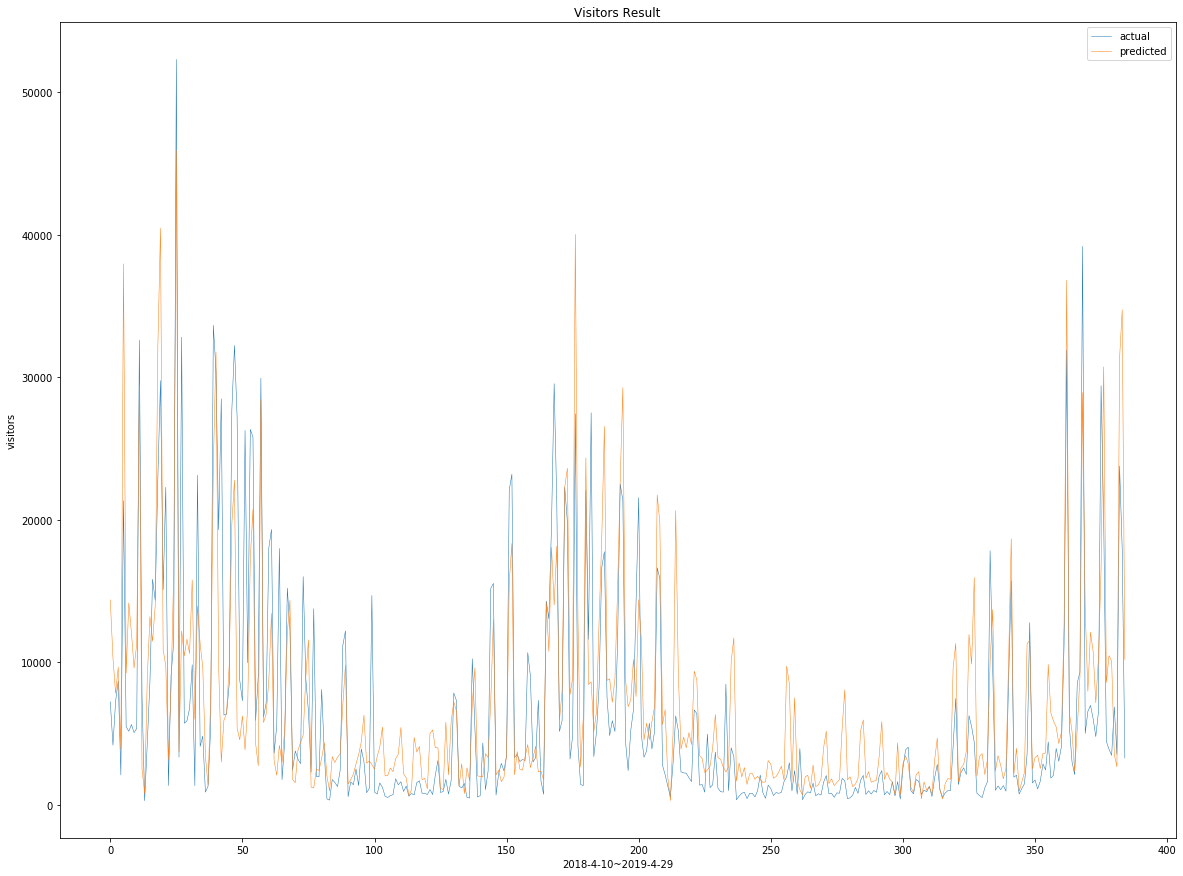

mae :  3156.3165559842987
mse :  23751481.450252745
rmse :  4873.549163623236
std : 4811.845992966123


In [10]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=70, batch_size=50, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/70
3847/3847 [==============================] - 18s 5ms/step - loss: 0.0113 - val_loss: 0.0030

Epoch 00001: val_loss improved from inf to 0.00303, saving model to DNNLSTMWmodel.h5
Epoch 2/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0046 - val_loss: 0.0027

Epoch 00002: val_loss improved from 0.00303 to 0.00271, saving model to DNNLSTMWmodel.h5
Epoch 3/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0042 - val_loss: 0.0037

Epoch 00003: val_loss did not improve from 0.00271
Epoch 4/70
3847/3847 [==============================] - 4s 991us/step - loss: 0.0040 - val_loss: 0.0061

Epoch 00004: val_loss did not improve from 0.00271
Epoch 5/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0038 - val_loss: 0.0033

Epoch 00005: val_loss did not improve from 0.00271
Epoch 6/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.

3847/3847 [==============================] - 4s 1ms/step - loss: 0.0025 - val_loss: 0.0028

Epoch 00052: val_loss did not improve from 0.00239
Epoch 53/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0026 - val_loss: 0.0043

Epoch 00053: val_loss did not improve from 0.00239
Epoch 54/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0025 - val_loss: 0.0028

Epoch 00054: val_loss did not improve from 0.00239
Epoch 55/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0025 - val_loss: 0.0033

Epoch 00055: val_loss did not improve from 0.00239
Epoch 56/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0025 - val_loss: 0.0033

Epoch 00056: val_loss did not improve from 0.00239
Epoch 57/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0024 - val_loss: 0.0030

Epoch 00057: val_loss did not improve from 0.00239
Epoch 58/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.002

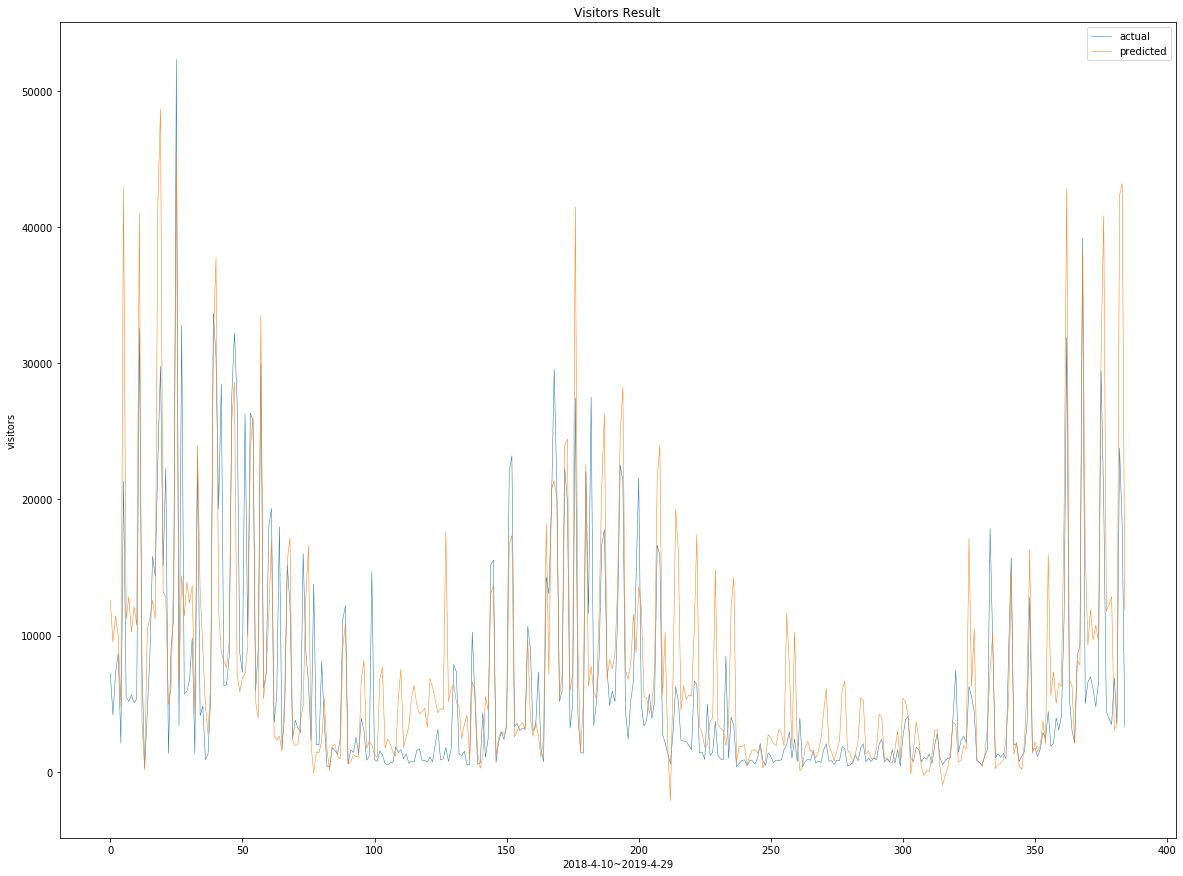

mae :  3355.1029106041055
mse :  28336944.169679116
rmse :  5323.2456424327365
std : 5140.216085920964


In [11]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=70, batch_size=50, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

학습 데이터 수: 4809
테스트 데이터 수: 385
Train on 3847 samples, validate on 962 samples
Epoch 1/70
3847/3847 [==============================] - 19s 5ms/step - loss: 0.0110 - val_loss: 0.0037

Epoch 00001: val_loss improved from inf to 0.00366, saving model to DNNLSTMWmodel.h5
Epoch 2/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0046 - val_loss: 0.0027

Epoch 00002: val_loss improved from 0.00366 to 0.00271, saving model to DNNLSTMWmodel.h5
Epoch 3/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0040 - val_loss: 0.0043

Epoch 00003: val_loss did not improve from 0.00271
Epoch 4/70
3847/3847 [==============================] - 4s 975us/step - loss: 0.0037 - val_loss: 0.0051

Epoch 00004: val_loss did not improve from 0.00271
Epoch 5/70
3847/3847 [==============================] - 4s 991us/step - loss: 0.0036 - val_loss: 0.0050

Epoch 00005: val_loss did not improve from 0.00271
Epoch 6/70
3847/3847 [==============================] - 4s 970us/step - loss

3847/3847 [==============================] - 4s 1ms/step - loss: 0.0025 - val_loss: 0.0049

Epoch 00052: val_loss did not improve from 0.00222
Epoch 53/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0025 - val_loss: 0.0035

Epoch 00053: val_loss did not improve from 0.00222
Epoch 54/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0026 - val_loss: 0.0027

Epoch 00054: val_loss did not improve from 0.00222
Epoch 55/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0024 - val_loss: 0.0028

Epoch 00055: val_loss did not improve from 0.00222
Epoch 56/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0025 - val_loss: 0.0030

Epoch 00056: val_loss did not improve from 0.00222
Epoch 57/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.0025 - val_loss: 0.0033

Epoch 00057: val_loss did not improve from 0.00222
Epoch 58/70
3847/3847 [==============================] - 4s 1ms/step - loss: 0.002

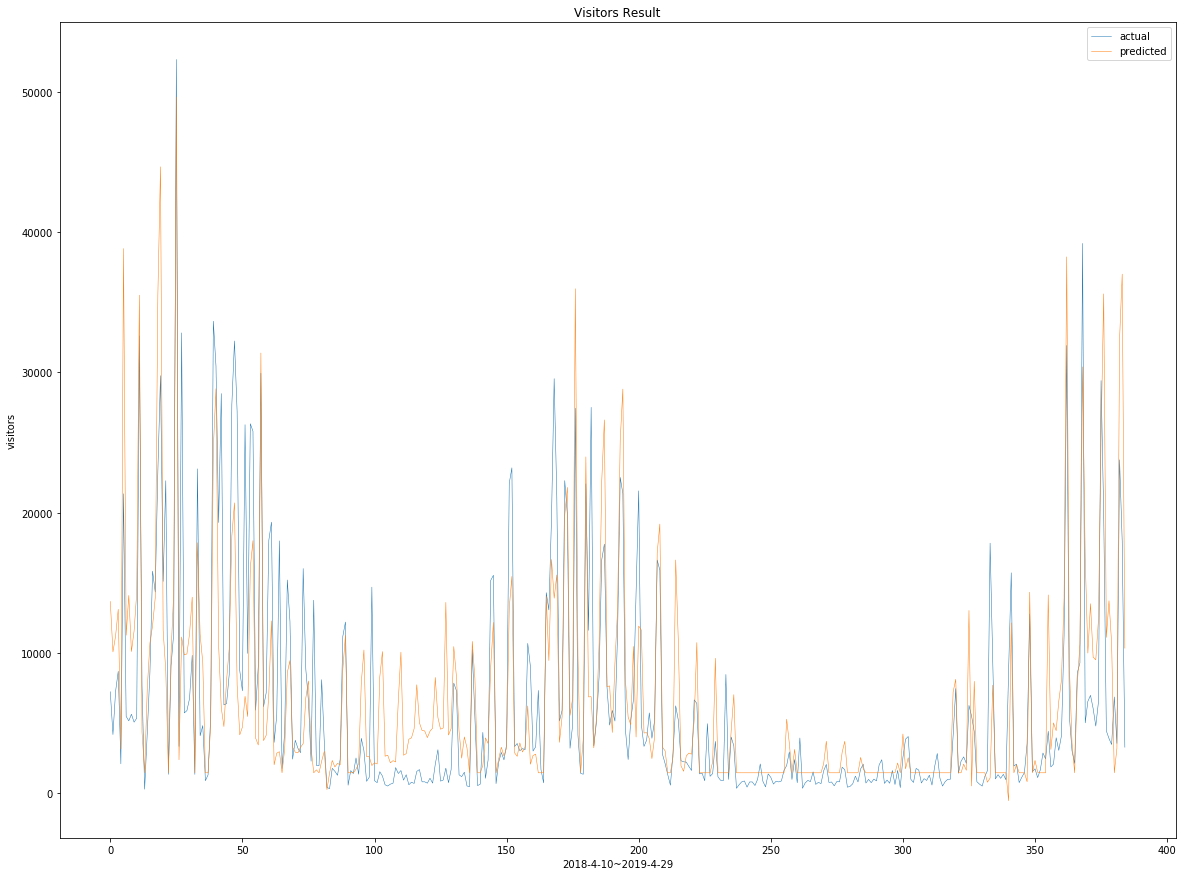

mae :  3063.2908409217735
mse :  25030346.000093926
rmse :  5003.0336796881475
std : 4991.692372725356


In [12]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark2.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_last = '2018-4-16'
split_date_start = '2017-8-29'
#+8달부터 계산된다.
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
train = df.loc[:split_date_last]
test = df.loc[split_date_start:]

trainLSTM = df.loc[:split_date_last, ['일계']]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

trainLSTM['일계'] = trainLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')

trainLSTM['일계'] = trainLSTM['일계'].astype('float')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#***************************주단위 데이터로 변환.**************************************************
train2LSTM = trainLSTM.iloc[0:0]
traintmp2 = trainLSTM.copy()
for i in range(int(len(trainLSTM)/7)):
    traintmp = trainLSTM['일계'][i*7:i*7+7]
    traintmp2['일계'][i*7+6] = traintmp.mean(axis = 0)
    train2LSTM = pd.concat([train2LSTM, traintmp2[i*7+6:i*7+7]], axis=0)
    
test2LSTM = testLSTM.iloc[0:0]
testtmp2 = testLSTM.copy()
for i in range(int(len(testLSTM)/7)):
    testtmp = testLSTM['일계'][i*7:i*7+7]
    testtmp2['일계'][i*7+6] = testtmp.mean(axis = 0)
    test2LSTM = pd.concat([test2LSTM, testtmp2[i*7+6:i*7+7]], axis=0)
#*****************************이어서 주단위 시계열 데이터 처리************************************
weekfrom = 2
weekto = 33
week = weekto - weekfrom

sc = MinMaxScaler()

train_sc2LSTM = sc.fit_transform(train2LSTM)
test_sc2LSTM = sc.transform(test2LSTM)

train_sc_df2LSTM = pd.DataFrame(train_sc2LSTM, columns=['Scaled'], index=train2LSTM.index)
test_sc_df2LSTM = pd.DataFrame(test_sc2LSTM, columns=['Scaled'], index=test2LSTM.index)

for s in range(weekfrom, weekto):
    train_sc_df2LSTM['shift_{}'.format(s)] = train_sc_df2LSTM['Scaled'].shift(s)
    test_sc_df2LSTM['shift_{}'.format(s)] = test_sc_df2LSTM['Scaled'].shift(s)

X_train2LSTM = train_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_test2LSTM = test_sc_df2LSTM.dropna().drop('Scaled', axis=1)

X_train2LSTMc = X_train2LSTM.iloc[0:0].copy()
for i in range(len(trainLSTM)):
    X_train2LSTMc = pd.concat([X_train2LSTMc, X_train2LSTM[int(i/7):int(i/7)+1]], axis=0)

X_test2LSTMc = X_test2LSTM.iloc[0:0].copy()
for i in range(len(testLSTM)):
    X_test2LSTMc = pd.concat([X_test2LSTMc, X_test2LSTM[int(i/7):int(i/7)+1]], axis=0)

#*****************************주단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_train2LSTMc = X_train2LSTMc.values
X_test2LSTMc= X_test2LSTMc.values

X_train_t2LSTMc = X_train2LSTMc.reshape(X_train2LSTMc.shape[0], week, 1)
X_test_t2LSTMc = X_test2LSTMc.reshape(X_test2LSTMc.shape[0], week, 1)
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()

train_scLSTM = sc.fit_transform(trainLSTM)
test_scLSTM = sc.transform(testLSTM)

train_sc_dfLSTM = pd.DataFrame(train_scLSTM, columns=['Scaled'], index=trainLSTM.index)
test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    train_sc_dfLSTM['shift_{}'.format(s)] = train_sc_dfLSTM['Scaled'].shift(s)
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_trainLSTM = train_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_trainLSTM = train_sc_dfLSTM.dropna()[['Scaled']]

X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]

X_trainLSTM = X_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]
y_trainLSTM = y_trainLSTM.iloc[weekto*7-dayto-6:-(len(trainLSTM)%7)]

X_testLSTM = X_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]
y_testLSTM = y_testLSTM.iloc[weekto*7-dayto-6:-(len(testLSTM)%7)]

#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_trainLSTM = X_trainLSTM.values
X_testLSTM = X_testLSTM.values

y_trainLSTM = y_trainLSTM.values
y_testLSTM = y_testLSTM.values

X_train_tLSTM = X_trainLSTM.reshape(X_trainLSTM.shape[0], day, 1)
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)
#******************************주단위 LSTM모델링**************************************************
model2 = Sequential() 
model2.add(LSTM(week, input_shape=(week, 1), return_sequences = True))
model2.add(LSTM(week))
model2.add(Dense(week, kernel_initializer='he_normal', activation='relu'))
#******************************일단위 LSTM모델링***************************************************
model = Sequential()
model.add(LSTM(day, input_shape=(day, 1), return_sequences = True))
model.add(LSTM(day))
model.add(Dense(day, activation='relu'))
#*********이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환***********************************
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
    
X_train = train_df.drop(['일계', '년도', '일'], axis=1)
y_train = train_df[['일계']]
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_train = X_train.iloc[weekto*7-7:-(len(trainLSTM)%7)]
X_test = X_test.iloc[weekto*7-7:-(len(testLSTM)%7)]

X_train = pd.get_dummies(X_train, columns=['요일', '월'])
X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

X_train_sc = sc2.fit_transform(X_train)
X_test_sc = sc2.transform(X_test)

y_train_sc = sc2.fit_transform(y_train)
y_test_sc = sc2.transform(y_test)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))
#*****************************************DNN 모델링*************************************************
class DNN(models.Sequential):
    def __init__(self, Nin):
        super().__init__()
 
        # 첫 번째 은닉층
        self.add(layers.Dense(500, kernel_initializer='he_normal', activation='relu',input_shape=(Nin,), name='Hidden-1'))
        self.add(layers.Dense(250, kernel_initializer='he_normal', activation='relu', name='Hidden-2'))
        self.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', name='Hidden-3'))
        self.add(layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
        
model3 = DNN(X_train_sc.shape[1])
#***************************일단위 LSTM모델과 DNN모델을 concatenate 및 모델 생성**********************
combinedInput = concatenate([model3.output, model2.output])

x = Dense(100, kernel_initializer='he_normal', activation='relu')(combinedInput)
x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
x = Dense(1)(x)

model4 = Model(inputs=[model3.input, model2.input], outputs=x)

opt = Adam(lr=0.001)
model4.compile(loss="mean_squared_error", optimizer=opt)
#************************************모델 학습************************************************************
mcp_save = ModelCheckpoint('DNNLSTMWmodel.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')

early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
model4.fit([X_train_sc, X_train_t2LSTMc], y_trainLSTM, validation_split = 0.2, epochs=70, batch_size=50, callbacks=[early_stop, mcp_save])

#모델 세이브
from keras.models import load_model
model4 = load_model('DNNLSTMWmodel.h5')
print("Model loaded")
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

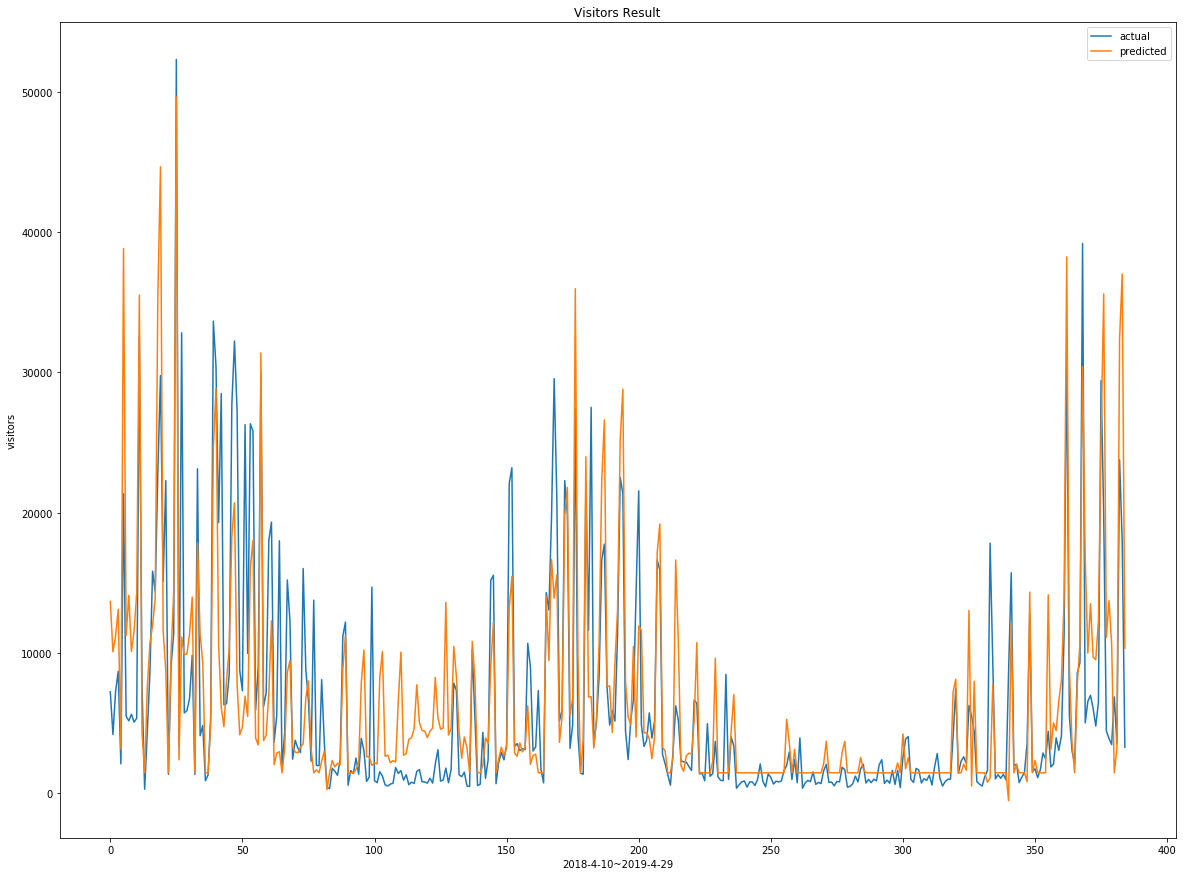

mae :  3063.2908409217735
mse :  25030346.000093926
rmse :  5003.0336796881475
std : 4991.692372725356


In [14]:
#**********************************plot을 이용한 그래프 그리기******************************************
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 1.5
plt.title('Visitors Result')
plt.xlabel(X_test.index.values[0] + '~' + X_test.index.values[-1])
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
Y_pred = model4.predict([X_test_sc, X_test_t2LSTMc])
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()
#********************************test셋에 대해서 오차값 구하기*******************************************
mse = np.square(ynewtest - ynew).mean()
rmse = mse ** 0.5
print("mae : ", np.absolute(ynewtest - ynew).mean())
print("mse : ", mse)
print("rmse : ", rmse)
print("std :", np.std(ynewtest-ynew))

In [15]:
print(np.absolute(ynewtest).mean())

6136.825974025974
